# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">


In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Restart the kernel and run the whole notebook again before you submit. 
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed.

<hr style="height:2pt">

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

## <div class="theme">  <b>Predicting Taxi Pickups in NYC</b> </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

### <div class="exercise"> <b> Question 1  [20 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is dependent on the time of the day.  Be sure to title your plot.

**1.3**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly surmise why this may be the case.  This will not be graded harshly, we just want you to think and communicate about the cause.


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [7]:
# read the file
nyc_taxi = pd.read_csv('data/nyc_taxi.csv', encoding='utf_8')
nyc_taxi.head()


,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [10]:
# split the data
train_data, test_data = train_test_split(nyc_taxi, test_size=0.2, random_state=42)
train_data.head()

#check shape of full, training, and testing data sets
# print("Shape of full dataset is: {0}".format(nyc_taxi.shape))
# print("Shape of training dataset is: {0}".format(train_data.shape))
# print("Shape of test dataset is: {0}".format(test_data.shape))

,TimeMin,PickupCount
1194,404.0,5.0
911,131.0,17.0
422,85.0,13.0
670,539.0,36.0
931,1266.0,46.0


**1.2 Generate a scatter plot of the training data points**


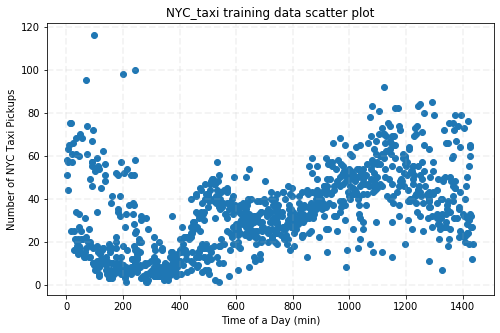

In [18]:
# Your code here
#seperate predictors and outcome values
x_train = train_data.TimeMin
y_train = train_data.PickupCount

#make scatter plot

def pretty_plot(x, y, title, xlabel, ylabel):    
    #Source: inspired from prelab and lab 3 exercise(s)
    
    # create figure
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    
    # create title
    ax.set_title(title)
    
    # create axes labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # create grid
    ax.grid(True, lw=1.75, ls='--', alpha=0.15)

    # create plot
    ax.scatter(x, y);
    
    return ax

pretty_plot(x_train, y_train, 'NYC_taxi training data scatter plot', 'Time of a Day (min)', 'Number of NYC Taxi Pickups');



**1.3 In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**

Assuming the beginning of the day is 0:00am:

It is looking like between 200min(3.3am) and 1200min (~8pm), there is a positive linear correlation between time of day and number of NYC taxi pickups. Meaning that there are on average more taxi pickups as the time of day increases. However, on the extremes ie. before ~3am and after 8pm, it looks like there is a lot more variance between the data points and it is less easy to predict the number of pickups given a certain timeframe. This makes intuitive sense because one would expect day-time taxi patterns to be more predictable than night-time taxi patterns with night-time taxi patterns being very dependent on weekday vs weekend for example. 



**1.4 You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes...**

The 500-550min corresponds to the 8:30-9am timeframe which I would expect is when a lot of people in NYC would take a taxi to work on the weekdays and not on the weekends. I suspect that the lower pickup numbers correspond to weekends while the higher ones correspond to week days. 



<hr>

### <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary...** 

In [117]:
# your code here
#Training and testing data sets
#training
x_train = np.array(train_data.TimeMin)
x_train = x_train.reshape(x_train.shape[0], 1)

y_train = np.array(train_data.PickupCount)
Y_train = y_train.reshape(y_train.shape[0], 1)


#test
x_test = np.array(test_data.TimeMin)
x_test = x_test.reshape(x_test.shape[0], 1)

y_test = np.array(test_data.PickupCount)


#create dictionary
KNNModels = {}

k_list = [1,10,75,250,500,750,1000]

for k in k_list:
    KNNReg = KNeighborsRegressor(n_neighbors=k)
    KNNReg.fit(x_train, y_train)
    KNNModels[k] = KNNReg

KNNModels

{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'),
 75: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                     weights='uniform'),
 250: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform'),
 500: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform'),
 750: KNeighborsRegressor(algorit

**2.2  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set...**

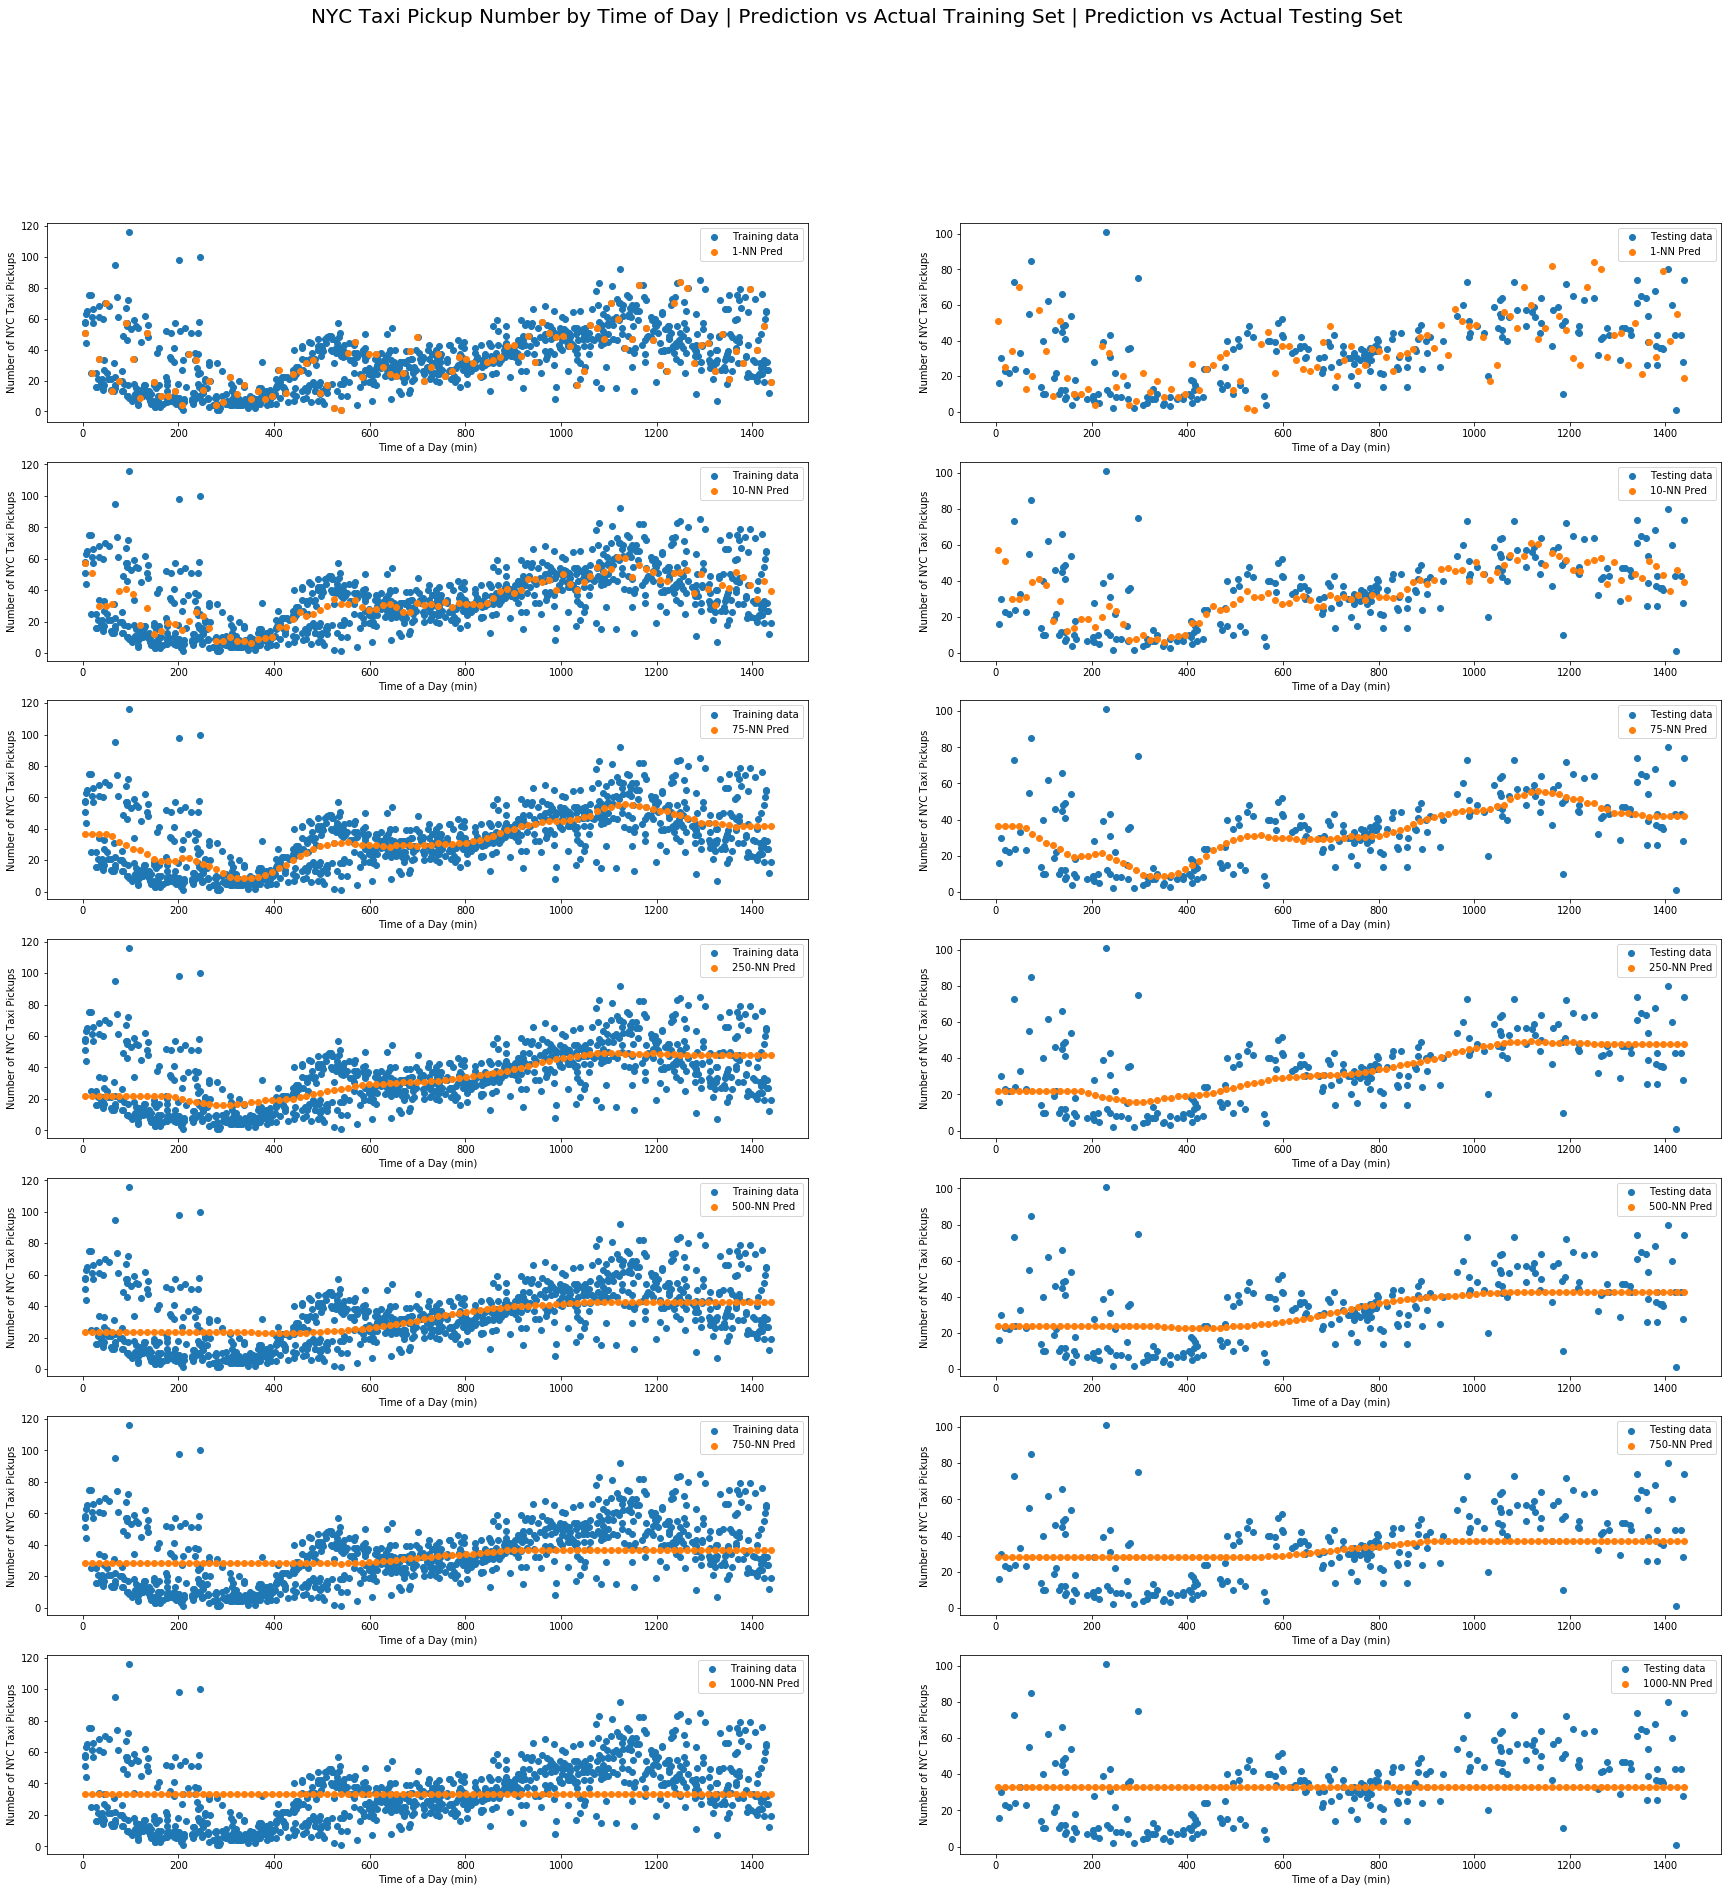

In [127]:
# your code here 

#make figure
fig, ax = plt.subplots(7,2, figsize=(30,30))
fig.suptitle("NYC Taxi Pickup Number by Time of Day | Prediction vs Actual Training Set | Prediction vs Actual Testing Set", fontsize=20)
    
#make subplots
row = 0
xgrid = np.linspace(np.min(x_train), np.max(x_train), 100)

for k, regressor in KNNModels.items():
    predictions = regressor.predict(xgrid.reshape(-1,1)) 
    #Prediction vs Training subplots in first column
    ax[row,0].scatter(x_train, y_train, label="Training data")
    ax[row,0].scatter(xgrid, predictions, label="{}-NN Pred".format(k))
    ax[row,0].legend();
    ax[row,0].set_xlabel("Time of a Day (min)")
    ax[row,0].set_ylabel("Number of NYC Taxi Pickups")
    
    #Prediction vs Testing subplots in second column
    ax[row,1].scatter(x_test, y_test, label="Testing data")
    ax[row,1].scatter(xgrid, predictions, label="{}-NN Pred".format(k))
    ax[row,1].legend();
    ax[row,1].set_xlabel("Time of a Day (min)")
    ax[row,1].set_ylabel("Number of NYC Taxi Pickups")
    
    
    row += 1


**2.3 Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**


In [132]:
# your code here
scores_train = []
scores_test = []

# Calculate R^2 score
for k, regressor in KNNModels.items():
    score_train = regressor.score(x_train, y_train) 
    score_test = regressor.score(x_test, y_test) 
    scores_train.append(score_train)
    scores_test.append(score_test)

print("R^2 scores for the training set are: {}.\nR^2 scores for the testing set are:{}".format(scores_train, scores_test))

R^2 scores for the training set are: [0.7123359249551393, 0.5098253543055764, 0.4453919898034398, 0.35531377106191797, 0.29032710753986246, 0.17943381356152266, 0.0].
R^2 scores for the testing set are:[-0.418931841502846, 0.2720679800405935, 0.39030979691560475, 0.3403408367444192, 0.2703208352566887, 0.16490939267081106, -0.0003843303764170524]


**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

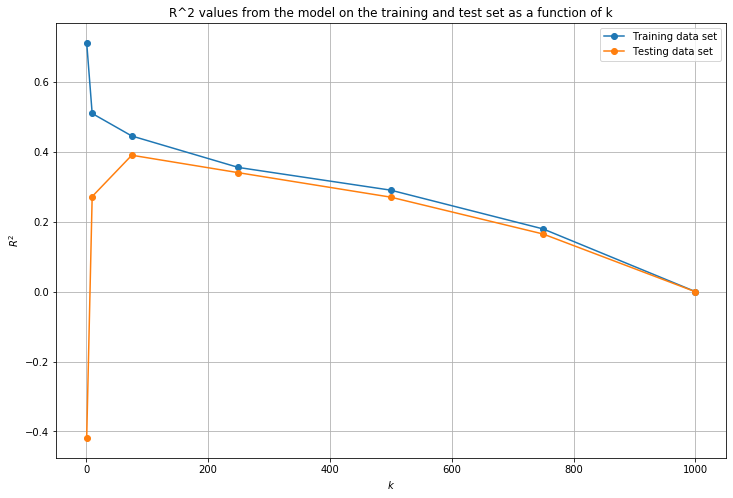

In [141]:
# your code here
# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(k_list, scores_train,'o-', label = "Training data set")
ax.plot(k_list, scores_test,'o-', label = "Testing data set")
ax.set_title("R^2 values from the model on the training and test set as a function of k")
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
ax.grid(True)
ax.legend();



**2.5 Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

It will trend towards 0 as can be seen above with the k = 1000 R^2 value.

2. What does an $R^2$ score of $0$ mean?  

It means that the model explains none of the variability of the data set.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

A negative R^2 means that the model explains the observed data set less well than a horizontal line. We calculated a negative R^2 with k close to 0. 

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

The R^2 values for the training data set start off very high when k close to 0 (ie. R^2 is close to 70%) while the testing data ones start off very low. Then, the training R^2 values decrease and the testing ones increase until about k = 75, at which point they follow a similar, downward sloping curve.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

The best value of k is 75 because it does the best job at predicting the test data without overfitting. 

6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).** ****

On the plots in 2.2., we see that the plots for k = 75 give enough of a trend as opposed to the lower k values and maintains enough granularity/accuracy as opposed to the hight values of k. 

<hr>

### <div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the estimates for the slope and intercept for the fitted linear model.  

**3.5**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable...**

In [191]:
# your code here
#adding constant
X_train = sm.add_constant(x_train)
#print(X_train)

# OLS model
model = sm.OLS(y_train, X_train)

#fit linear regression model on training set
OLSModel = model.fit()

# pull beta param out
beta0 = OLSModel.params[0]
beta1 = OLSModel.params[1]


**3.2 Create a plot just like you did in 2.2 (but with fewer subplots)...** 

Text(0, 0.5, 'Number of NYC Taxi Pickups')

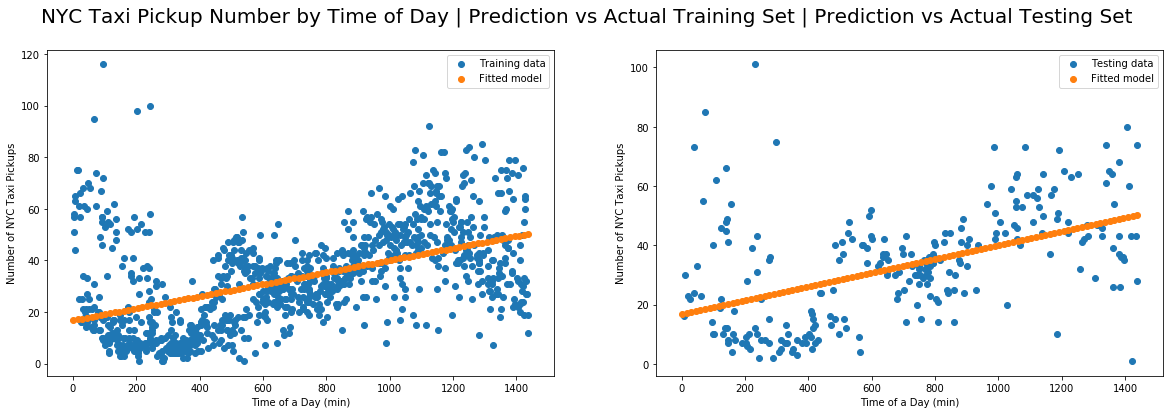

In [192]:
# your code here 

#make figure
fig, ax = plt.subplots(1,2, figsize=(20,6))
fig.suptitle("NYC Taxi Pickup Number by Time of Day | Prediction vs Actual Training Set | Prediction vs Actual Testing Set", fontsize=20)
    
#make subplots
xgrid = np.linspace(np.min(X_train), np.max(X_train), 100)
fitted_line = beta0 + xgrid * beta1

#Prediction vs Training subplots in first column
ax[0].scatter(x_train, y_train, label="Training data")
ax[0].scatter(xgrid, fitted_line , label="Fitted model")
ax[0].legend();
ax[0].set_xlabel("Time of a Day (min)")
ax[0].set_ylabel("Number of NYC Taxi Pickups")
    
#Prediction vs Testing subplots in second column
ax[1].scatter(x_test, y_test, label="Testing data")
ax[1].scatter(xgrid, fitted_line , label="Fitted model")
ax[1].legend();
ax[1].set_xlabel("Time of a Day (min)")
ax[1].set_ylabel("Number of NYC Taxi Pickups")

**3.3 Report the $R^2$ score for the fitted model on both the training and test sets.**


In [193]:
# your code here
print(OLSModel.rsquared)

#TODO: how to get R squared for testing data set


0.2430260353189334


**3.4 Report the estimates for the slope and intercept for the fitted linear model.**

In [194]:
# your code here
print("Beta0 = {}, Beta1 = {}".format(beta0, beta1))


Beta0 = 16.750601427446817, Beta1 = 0.023335175692397344


**3.5 Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 


In [203]:
# your code here
#Source:https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

from statsmodels.sandbox.regression.predstd import wls_prediction_std

prstd, iv_l, iv_u = wls_prediction_std(OLSModel)
print("Confidence interval for Beta0: Lower bound is: {} and Upper bound is: {}".format(iv_l[0], iv_u[0]))
print("Confidence interval for Beta1: Lower bound is: {} and Upper bound is: {}".format(iv_l[1], iv_u[1]))

Confidence interval for Beta0: Lower bound is: -6.602876747843055 and Upper bound is: 58.958901562193745
Confidence interval for Beta1: Lower bound is: -12.997108512837983 and Upper bound is: 52.61212739913972


**3.6 Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

*your answer here*

2. What does the sign of the slope of the fitted linear model convey about the data?  

*your answer here*


3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 


*your answer here*


4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  


*your answer here*

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

*your answer here*

<hr>

## <div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or even one correct definition of an outlier).**


### <div class="exercise"><b> Question 4 [30 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of potential outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x`, `dataset_y`, and `num_outliers` representing your features, response variable values (make sure your response variable is stored as a numpy column vector), and the number of outliers to remove.  Your algorithm should select the `num_outliers` most extreme residuals from the linear regression model to predict, `dataset_y` from `dataset_x`.  The return value should be a list `outlier_indices` representing the indices of the `num_outliers` outliers in the original datasets you passed in.  Apply your function to the training data in order to identify 3 outliers.  Use `statsmodels` to create a Linear Regression model on the remaining training set data (with the 3 outliers removed), and store your model in the variable `OutlierFreeSimpleModel`.

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Propose how you would alter and/or use the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

### Answers
**4.1  We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?** 

In [212]:
#TODO

*your answer here*
  


**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.**



In [213]:
# your code here
# read the data
outliers_train = pd.read_csv('data/outliers_train.csv', encoding='utf_8')
outliers_train.head()

X = outliers_train.X
Y = outliers_train.Y

#adding constant
X_outliers = sm.add_constant(X)
#print(X_train)

# OLS model
Outliers_model = sm.OLS(Y, X_outliers)

#fit linear regression model on training set
OutlierOLSModel = Outliers_model.fit()

# pull beta param out
beta0_o = OutlierOLSModel.params[0]
beta1_o = OutlierOLSModel.params[1]

print("Beta0 = {}, Beta1 = {}".format(beta0_o, beta1_o))

Beta0 = -9.506264135716679, Beta1 = 47.3554226118558


**4.3 You're given the knowledge ahead of time that there are 3 outliers...Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  

*your answer here*
TODO

**4.4  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data...**

In [10]:
def find_outliers_simple(dataset_x, dataset_y, num_outliers):
    # your code here
    
    
    return list(outlier_indices)

In [8]:
# get outliers and calculate outlier model
# your code here


**4.5 Create a figure with two subplots: the first is a scatterplot where the color of the points...**


In [9]:
# plot 
# your code here



*your answer here*


**4.6 Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**


In [10]:
# your code here


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers...**

*your answer here*
